# Importing Libraries

In [1]:
# Importing Libraries
import os, pickle, glob, sys
from pyspark.sql import SparkSession, Row
from pyspark.sql import functions as F
import seaborn as sns
from pyspark.sql.functions import col, when, udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DoubleType
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt

Matplotlib created a temporary cache directory at /tmp/matplotlib-o8ucle74 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# Initializing SparkSession
sc = SparkSession.builder \
    .config("spark.driver.memory", "10g") \
	.config("spark.executor.memory", "10g") \
    .config('spark.executor.instances', 5) \
	.getOrCreate()
print(sc)

In [4]:
# First time data zip unpacking
#!unzip ./traffic_congestion.zip

In [5]:
csv_file = "./us_congestion_2016_2022/us_congestion_2016_2022.csv"

In [5]:
df = sc.read.csv(csv_file, header=True, inferSchema=True)

# Exploring Data

In [6]:
# Inspecting First Row
first_row = df.take(1)[0]
print(first_row)

Row(ID='C-1', Severity=0, Start_Lat=42.410881, Start_Lng=-71.147995, StartTime=datetime.datetime(2020, 11, 10, 14, 54), EndTime=datetime.datetime(2020, 11, 10, 16, 29, 27), Distance(mi)=3.990000009536743, DelayFromTypicalTraffic(mins)=0.0, DelayFromFreeFlowSpeed(mins)=4.0, Congestion_Speed='Moderate', Description='Delays of four minutes and delays increasing on Massachusetts Ave Westbound between MA-2A Massachusetts Ave and US-3 Mass Ave. Average speed 15 mph.', Street='Wyman Ter', City='Arlington', County='Middlesex', State='MA', Country='US', ZipCode='02474-6726', LocalTimeZone='US/Eastern', WeatherStation_AirportCode='KBED', WeatherTimeStamp=datetime.datetime(2020, 11, 10, 14, 51), Temperature(F)=64.0, WindChill(F)=64.0, Humidity(%)=63.0, Pressure(in)=29.93, Visibility(mi)=10.0, WindDir='SSW', WindSpeed(mph)=7.0, Precipitation(in)=0.0, Weather_Event=None, Weather_Conditions='Fair')


In [7]:
# Check the schema
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- StartTime: timestamp (nullable = true)
 |-- EndTime: timestamp (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- DelayFromTypicalTraffic(mins): double (nullable = true)
 |-- DelayFromFreeFlowSpeed(mins): double (nullable = true)
 |-- Congestion_Speed: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- ZipCode: string (nullable = true)
 |-- LocalTimeZone: string (nullable = true)
 |-- WeatherStation_AirportCode: string (nullable = true)
 |-- WeatherTimeStamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- WindChill(F): double (nullable = true)
 |-- Humidity(%): double 

In [8]:
def shape(df):
    num_rows = df.count()
    num_cols = len(df.columns)
    return num_rows, num_cols

df_rows, df_cols = shape(df)
print("DataFrame has {} rows and {} columns.".format(df_rows, df_cols))

DataFrame has 33304199 rows and 30 columns.


# Data Cleaning and Filtering

In [9]:

df = df.drop("Weather_Event") #deletes weather event beacuse 96% of that column is null
df = df.sample(withReplacement=False, fraction=0.05) 

In [10]:

# Handle missing values
df = df.dropna()

# Remove duplicates
df = df.dropDuplicates()


In [11]:
df_rows, df_cols = shape(df)
print("DataFrame has {} rows and {} columns.".format(df_rows, df_cols))

DataFrame has 896858 rows and 29 columns.


In [12]:
# Filtering Fields
# Filter out specific fields we want to keep
fields_to_keep = ['ID', 'Severity','State', 'DelayFromFreeFlowSpeed(mins)', 'StartTime', 'Congestion_Speed', 'Pressure(in)', 'Visibility(mi)', 'WindSpeed(mph)', 'Precipitation(in)', 'Weather_Conditions']

# Filter out data that might be useless, like Delays that are less than 5 minutes. Reduces data to around 5 million data
filtered_df = df.select(*fields_to_keep).where(col("State").isNotNull()).where(col("DelayFromFreeFlowSpeed(mins)") > 5.0)
filtered_df.show()

+--------+--------+-----+----------------------------+-------------------+----------------+------------+--------------+--------------+-----------------+--------------------+
|      ID|Severity|State|DelayFromFreeFlowSpeed(mins)|          StartTime|Congestion_Speed|Pressure(in)|Visibility(mi)|WindSpeed(mph)|Precipitation(in)|  Weather_Conditions|
+--------+--------+-----+----------------------------+-------------------+----------------+------------+--------------+--------------+-----------------+--------------------+
|  C-1250|       2|   NY|                        24.0|2020-11-10 11:09:00|            Slow|       30.23|           6.0|           7.0|              0.0|                Fair|
| C-14851|       1|   GA|                         9.0|2020-11-10 23:05:00|            Slow|       28.88|           6.0|           8.0|              0.0|              Cloudy|
| C-16403|       2|   MO|                         6.0|2020-11-10 12:20:00|        Moderate|       28.89|          10.0|           

In [13]:
# Grouping by State
state_count_df = filtered_df.groupBy("State").count()
state_count_df.show()

+-----+-----+
|State|count|
+-----+-----+
|   AZ| 2224|
|   SC| 2738|
|   LA| 3335|
|   MN| 1997|
|   NJ| 5762|
|   DC|  894|
|   OR| 2789|
|   VA| 4469|
|   RI|  462|
|   KY| 1830|
|   WY|  891|
|   NH|  699|
|   MI| 4632|
|   NV|  673|
|   WI| 1335|
|   ID|  702|
|   CA|26614|
|   CT| 3219|
|   NE|  923|
|   MT|  957|
+-----+-----+
only showing top 20 rows



In [14]:
# Cleaning 'Congestion_Speed' Column
df = df.withColumn("Congestion_Speed", when(col("Congestion_Speed") == "Slow", 0).when(col("Congestion_Speed") == "Moderate", 1).when(col("Congestion_Speed") == "Fast", 2))
df.select("Congestion_Speed").show()

+----------------+
|Congestion_Speed|
+----------------+
|               0|
|               0|
|               1|
|               1|
|               0|
|               1|
|               1|
|               1|
|               2|
|               2|
|               1|
|               1|
|               1|
|               1|
|               1|
|               1|
|               2|
|               1|
|               2|
|               2|
+----------------+
only showing top 20 rows



In [15]:
# Grouping by 'Weather_Conditions' and Counting
weather_counts = filtered_df.groupBy("Weather_Conditions").count()
weather_counts.show()
#Thunderstorm, Rain, Fog, Snow, Tornado, Hail

+--------------------+-----+
|  Weather_Conditions|count|
+--------------------+-----+
|Light Rain Shower...|    1|
|         Ice Pellets|   19|
|         Shallow Fog|   57|
|Light Snow with T...|   12|
|         Light Sleet|   15|
|  Light Snow / Windy|  779|
|   N/A Precipitation|  252|
|Freezing Rain / W...|    3|
|Showers in the Vi...|   25|
|              Cloudy|27668|
|    Thunder and Hail|    1|
|  Wintry Mix / Windy|   26|
|     T-Storm / Windy|   35|
| Heavy Sleet / Windy|    1|
| Light Freezing Rain|  478|
|          Wintry Mix|  646|
|        Blowing Snow|   59|
|  Heavy Rain / Windy|   34|
|     Thunder / Windy|   41|
|Heavy Thunderstor...|    6|
+--------------------+-----+
only showing top 20 rows



In [16]:
# 1. Extract columns for the Accident table
accident_df = df.select(
    "ID", "Severity", "Start_Lat", "Start_Lng",
    "StartTime", "EndTime", "Distance(mi)",
    "DelayFromTypicalTraffic(mins)",
    "DelayFromFreeFlowSpeed(mins)", "Description"
)

# 2. Extract columns for the Location table
location_df = df.select(
    "ID", "Street", "City", "County", "State",
    "Country", "ZipCode", "LocalTimeZone"
)

# 3. Extract columns for the Weather table
weather_df = df.select(
    "ID", "WeatherStation_AirportCode", "WeatherTimeStamp",
    "Temperature(F)", "WindChill(F)", "Humidity(%)",
    "Pressure(in)", "Visibility(mi)", "WindDir",
    "WindSpeed(mph)", "Precipitation(in)",
    "Weather_Conditions"
)

testing_df = df.select(
    'ID', 'Severity', 'DelayFromFreeFlowSpeed(mins)', 'StartTime', 
    'Congestion_Speed', 'Pressure(in)', 'Visibility(mi)', 
    'WindSpeed(mph)', 'Precipitation(in)'
)

# Write the normalized DataFrames to separate Parquet files
accident_df.write.mode("overwrite").parquet(f"{os.getcwd()}/parquet_data/accident_df.parquet")
location_df.write.mode("overwrite").parquet(f"{os.getcwd()}/parquet_data/location_table.parquet")
weather_df.write.mode("overwrite").parquet(f"{os.getcwd()}/parquet_data/weather_table.parquet")
testing_df.write.mode("overwrite").parquet(f"{os.getcwd()}/parquet_data/testing_df.parquet")

# Data Visualization

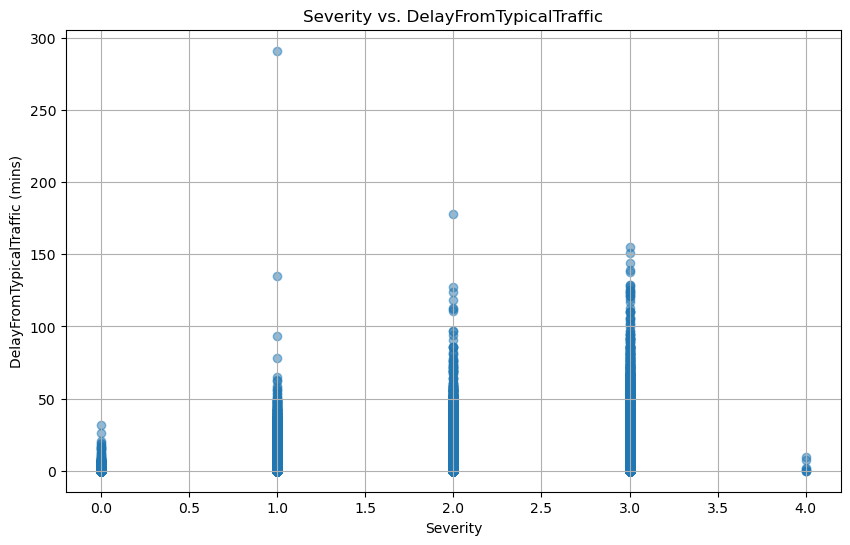

In [17]:
import matplotlib.pyplot as plt

# Read the Parquet file containing the Accident Table
accident_df = sc.read.parquet(f"{os.getcwd()}/parquet_data/accident_df.parquet")

# Select only Severity and DelayFromTypicalTraffic columns
severity_delay_df = accident_df.select("Severity", "DelayFromTypicalTraffic(mins)")

# Convert DataFrame to Pandas DataFrame
severity_delay_pd = severity_delay_df.toPandas()

# Plot Severity vs. DelayFromTypicalTraffic
plt.figure(figsize=(10, 6))
plt.scatter(severity_delay_pd['Severity'], severity_delay_pd['DelayFromTypicalTraffic(mins)'], alpha=0.5)
plt.title('Severity vs. DelayFromTypicalTraffic')
plt.xlabel('Severity')
plt.ylabel('DelayFromTypicalTraffic (mins)')
plt.grid(True)
plt.show()

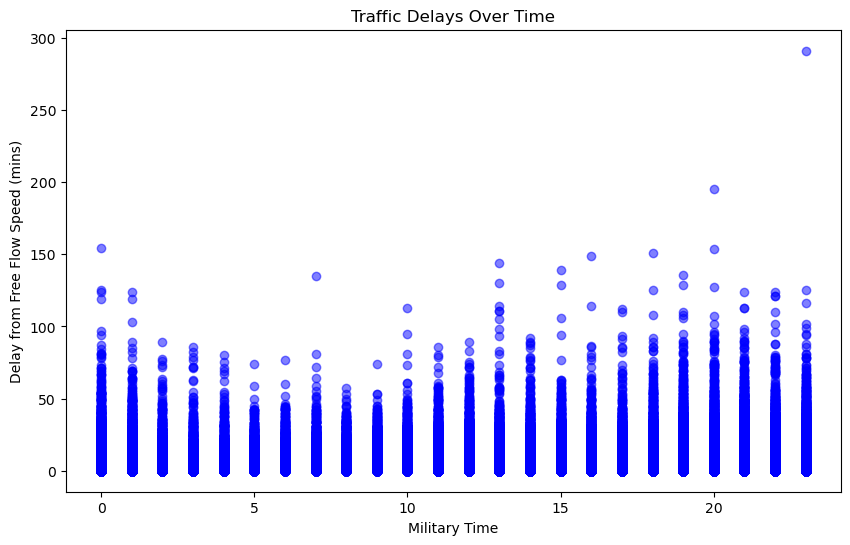

In [18]:
testing_df = sc.read.parquet(f"{os.getcwd()}/parquet_data/testing_df.parquet")
starttime_df = testing_df.select("DelayFromFreeFlowSpeed(mins)", "StartTime")
starttime_df = starttime_df.toPandas()

starttime_df['StartTime'] = pd.to_datetime(starttime_df['StartTime']).dt.hour


plt.figure(figsize=(10, 6))
plt.scatter(starttime_df['StartTime'], starttime_df['DelayFromFreeFlowSpeed(mins)'], color='b', alpha=0.5)
plt.title('Traffic Delays Over Time')
plt.xlabel('Military Time')
plt.ylabel('Delay from Free Flow Speed (mins)')
plt.show()

In [19]:
testing_df.show()

+--------+--------+----------------------------+-------------------+----------------+------------+--------------+--------------+-----------------+
|      ID|Severity|DelayFromFreeFlowSpeed(mins)|          StartTime|Congestion_Speed|Pressure(in)|Visibility(mi)|WindSpeed(mph)|Precipitation(in)|
+--------+--------+----------------------------+-------------------+----------------+------------+--------------+--------------+-----------------+
|  C-3328|       0|                         3.0|2020-11-10 15:44:00|               0|       30.18|          10.0|          12.0|              0.0|
|  C-6479|       0|                         2.0|2020-11-10 20:30:00|               1|       30.03|          10.0|           6.0|              0.0|
| C-12204|       0|                         4.0|2020-11-10 23:35:00|               1|       30.11|          10.0|           8.0|              0.0|
| C-12300|       0|                         2.0|2020-11-10 17:06:00|               1|       29.05|          10.0|     

In [20]:
# Added Weather_Event_Count and filtered out delays that aren't over 5 minutes
#df = testing_df.withColumn("Weather_Event_Count", F.size(F.split(testing_df["Weather_Event"], ";")))
df = df.where(col("DelayFromFreeFlowSpeed(mins)") > 5.0)

+--------+--------+-----------------+------------------+-------------------+-------------------+------------------+-----------------------------+----------------------------+----------------+--------------------+----------------+-------------+-------------+-----+-------+----------+-------------+--------------------------+-------------------+--------------+------------+-----------+------------+--------------+-------+--------------+-----------------+--------------------+
|      ID|Severity|        Start_Lat|         Start_Lng|          StartTime|            EndTime|      Distance(mi)|DelayFromTypicalTraffic(mins)|DelayFromFreeFlowSpeed(mins)|Congestion_Speed|         Description|          Street|         City|       County|State|Country|   ZipCode|LocalTimeZone|WeatherStation_AirportCode|   WeatherTimeStamp|Temperature(F)|WindChill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|WindDir|WindSpeed(mph)|Precipitation(in)|  Weather_Conditions|
+--------+--------+-----------------+---------------

In [21]:
df = df.toPandas()

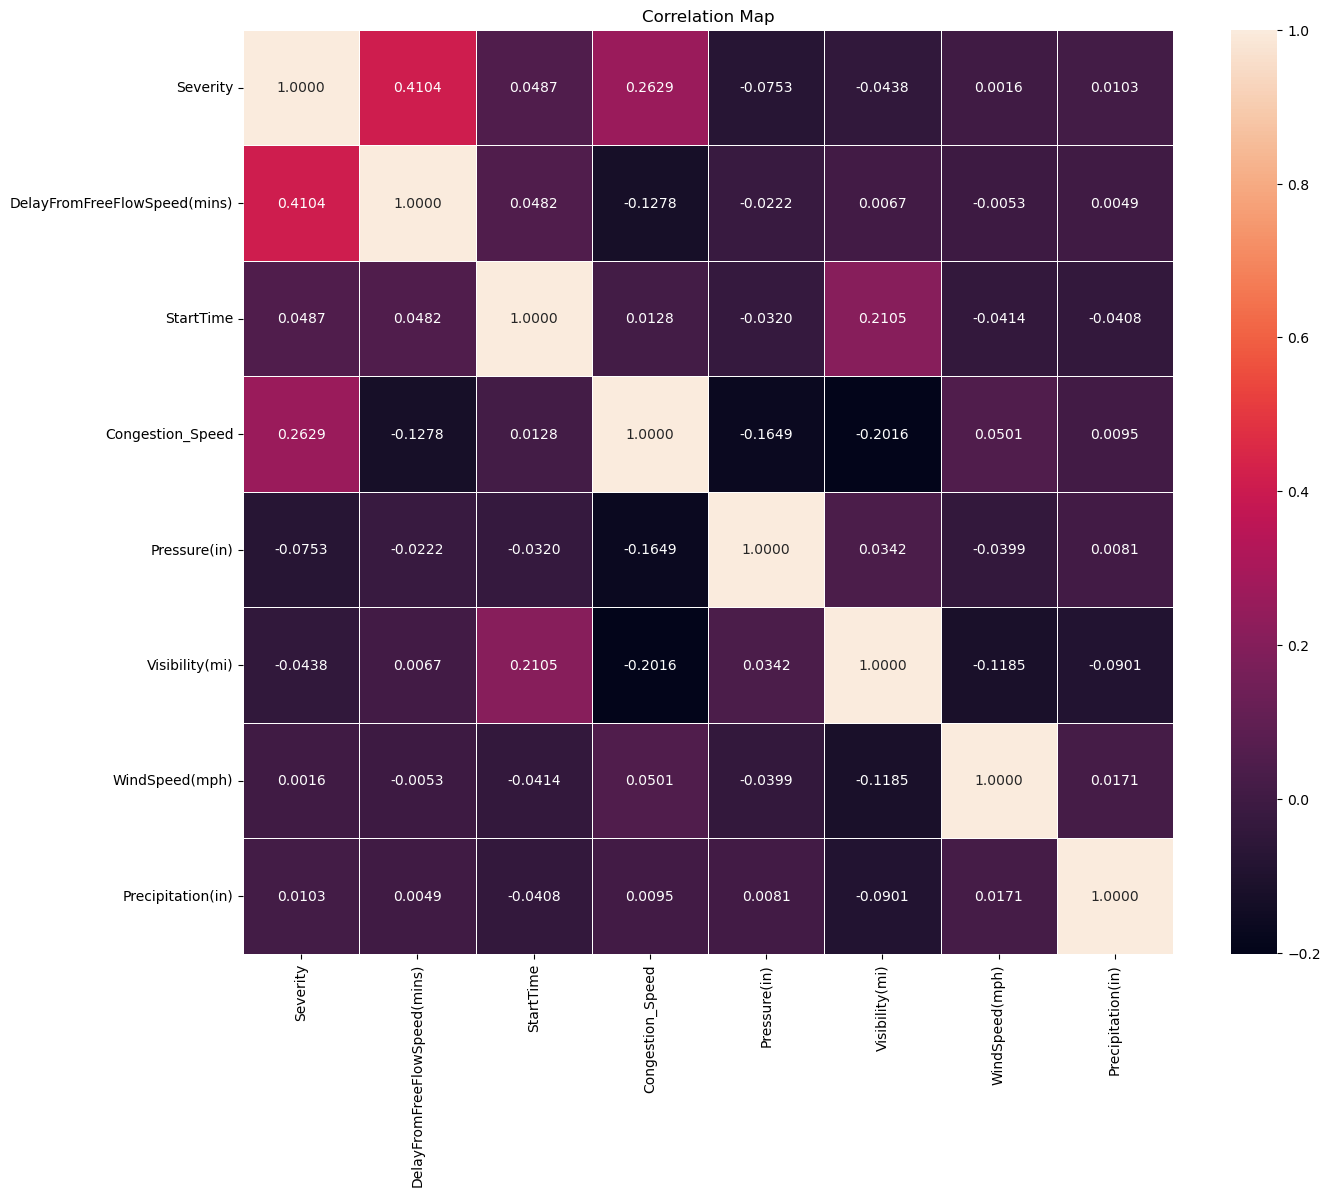

In [22]:
df_correlation = df[['Severity', 'DelayFromFreeFlowSpeed(mins)', 'StartTime', 'Congestion_Speed', 'Pressure(in)', 'Visibility(mi)', 'WindSpeed(mph)', 'Precipitation(in)']]
plt.figure(figsize=(15,12))
plt.title('Correlation Map')
sns.heatmap(df_correlation.corr(), annot=True, fmt=".4f", linewidths=0.5)
plt.show()

# XGB model

In [2]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report

In [3]:
accident_df = pd.read_parquet(os.getcwd() + "/parquet_data/accident_df.parquet")
weather_df = pd.read_parquet(os.getcwd() + "/parquet_data/weather_table.parquet")
testing_df = pd.read_parquet(os.getcwd() + "/parquet_data/testing_df.parquet")
location_df = pd.read_parquet(os.getcwd() + "/parquet_data/location_table.parquet")

intermediate_df = pd.merge(accident_df[["ID", "Severity", "Start_Lat", "Start_Lng","StartTime"]],weather_df[["ID", "Weather_Conditions"]], on="ID" , how = "inner")
intermediate_df = pd.merge(location_df[["ID", "ZipCode", "LocalTimeZone"]], intermediate_df, on = "ID" , how = "inner")
merged_df = pd.merge(intermediate_df, testing_df[["ID", "Visibility(mi)", "Congestion_Speed"]], on ="ID", how = "inner")


In [4]:
merged_df['StartTime'] = pd.to_datetime(merged_df['StartTime'])
merged_df['StartHour'] = merged_df['StartTime'].dt.hour

merged_df.head()

,ID,ZipCode,LocalTimeZone,Severity,Start_Lat,Start_Lng,StartTime,Weather_Conditions,Visibility(mi),Congestion_Speed,StartHour
0,C-1250,11414,US/Eastern,2,40.670364,-73.848763,2020-11-10 11:09:00,Fair,6.0,0,11
1,C-14851,30044-6985,US/Eastern,1,33.953861,-84.051537,2020-11-10 23:05:00,Cloudy,6.0,0,23
2,C-16403,64119,US/Central,2,39.182377,-94.523376,2020-11-10 12:20:00,Light Rain,10.0,1,12
3,C-17927,60469,US/Central,2,41.623470,-87.680466,2020-11-10 18:57:00,Cloudy / Windy,10.0,1,18
4,C-35543,11373-4242,US/Eastern,0,40.737541,-73.880379,2020-11-09 18:42:00,Fair,10.0,0,18


In [5]:
#GOAL: predict congestion speed (slow,moderate,fast) given the weather conditions, location, time, and severity of the location

In [6]:
#encode weather conditions using one hot encoding
encoder = OneHotEncoder(sparse_output=False)  # Use sparse=True to return a sparse matrix

# Fit and transform the data
encoded_data = encoder.fit_transform(merged_df[['Weather_Conditions']])

# Create a DataFrame with the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['Weather_Conditions']))


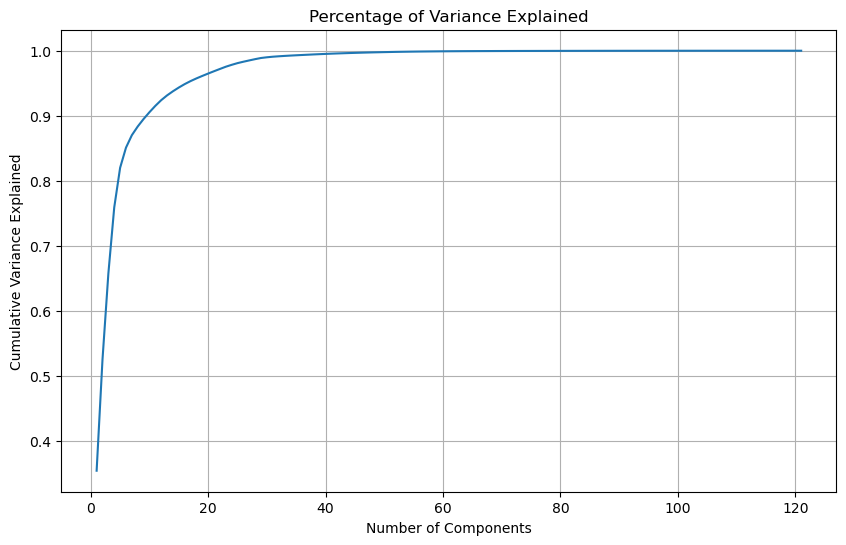

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(encoded_df)

# Calculate cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotting the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.title('Percentage of Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

In [18]:
pca = PCA(n_components= 40)
pca_result = pca.fit_transform(encoded_df)

# Convert the transformed data back to a DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])


In [9]:
concatenated_df =pd.concat([merged_df[["Severity","Start_Lat","Start_Lng", "StartHour"]], pca_df], axis=1)
print(concatenated_df.shape)
concatenated_df.head()

(896858, 125)


,Severity,Start_Lat,Start_Lng,StartHour,0,1,2,3,4,5,...,111,112,113,114,115,116,117,118,119,120
0,2,40.670364,-73.848763,11,-0.000014,-0.000027,-0.000293,-0.000143,-1.093418e-06,-0.000343,...,-1.093418e-06,-0.002866,-0.000009,-0.000016,-2.186846e-06,-2.186846e-06,-0.000009,-2.186846e-06,-0.003936,-0.000156
1,1,33.953861,-84.051537,23,-0.000003,-0.000005,-0.000055,-0.000027,-2.050056e-07,-0.000064,...,-2.050056e-07,-0.000543,-0.000002,-0.000003,-4.100147e-07,-4.100147e-07,-0.000002,-4.100147e-07,-0.000750,-0.000029
2,2,39.182377,-94.523376,12,0.000015,0.000029,0.000313,0.000153,1.164110e-06,0.000366,...,1.164110e-06,0.003106,0.000009,0.000017,2.328245e-06,2.328245e-06,0.000009,2.328245e-06,0.004294,0.000167
3,2,41.623470,-87.680466,18,0.000011,0.000021,0.000221,0.000108,8.202644e-07,0.000258,...,8.202644e-07,0.002207,0.000007,0.000012,1.640552e-06,1.640552e-06,0.000007,1.640552e-06,0.003062,0.000118
4,0,40.737541,-73.880379,18,0.000040,0.000078,0.000836,0.000407,3.100989e-06,0.000978,...,3.100989e-06,0.008559,0.000025,0.000047,6.202123e-06,6.202123e-06,0.000025,6.202123e-06,0.011993,0.000445


In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Fit and transform the features
concatenated_df[['Start_Lat', 'Start_Lng', 'StartHour']] = scaler.fit_transform(concatenated_df[['Start_Lat', 'Start_Lng', 'StartHour']])


In [31]:
X = concatenated_df
y = merged_df['Congestion_Speed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
X.head()

,Severity,Start_Lat,Start_Lng,StartHour,PC1,PC2,PC3,PC4,PC5,PC6,...,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
0,2,0.659253,0.882950,0.478261,0.641782,0.012697,-0.038591,-0.014825,-0.018307,-0.013156,...,-0.000062,-0.000082,-0.000013,-0.000044,0.000014,0.000004,0.000003,-0.000002,-0.000015,-0.000009
1,1,0.384568,0.705088,1.000000,-0.547529,0.718052,-0.321725,-0.079369,-0.070090,-0.042740,...,-0.000178,-0.000234,-0.000036,-0.000125,0.000041,0.000010,0.000009,-0.000006,-0.000042,-0.000025
2,2,0.598399,0.522536,0.521739,-0.321329,-0.035718,0.180029,0.121381,0.940980,-0.293137,...,-0.000612,-0.000799,-0.000124,-0.000428,0.000140,0.000036,0.000030,-0.000019,-0.000145,-0.000084
3,2,0.698232,0.641826,0.782609,-0.278480,-0.025678,0.113881,0.062503,0.147661,0.248005,...,-0.006373,-0.008003,-0.001224,-0.004185,0.001353,0.000345,0.000285,-0.000185,-0.001387,-0.000804
4,0,0.662000,0.882399,0.782609,0.641782,0.012697,-0.038591,-0.014825,-0.018307,-0.013156,...,-0.000062,-0.000082,-0.000013,-0.000044,0.000014,0.000004,0.000003,-0.000002,-0.000015,-0.000009


In [33]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Convert the data into DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': 3,  # Number of classes (0, 1, 2)
    'eta': 0.3,
    'max_depth': 8,
    # 'subsample': 0.8,
    # 'colsample_bytree': 0.8,
    'eval_metric': 'merror'  # Classification error
}
num_round = 500
evals = [(dtrain, 'train'), (dtest, 'eval')]
evals_result = {}  # Dictionary to store evaluation results

In [34]:
# Train the model

bst = xgb.train(params, dtrain, num_boost_round=num_round, evals=evals, evals_result=evals_result, verbose_eval=False)

In [35]:
# Predict on the test set
preds = bst.predict(dtest)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy}")

# Print classification report
print(classification_report(y_test, preds))

Accuracy: 0.651205316325848
              precision    recall  f1-score   support

           0       0.65      0.38      0.48     39062
           1       0.64      0.67      0.66     75065
           2       0.66      0.79      0.72     65245

    accuracy                           0.65    179372
   macro avg       0.65      0.61      0.62    179372
weighted avg       0.65      0.65      0.64    179372



<Figure size 1000x800 with 0 Axes>

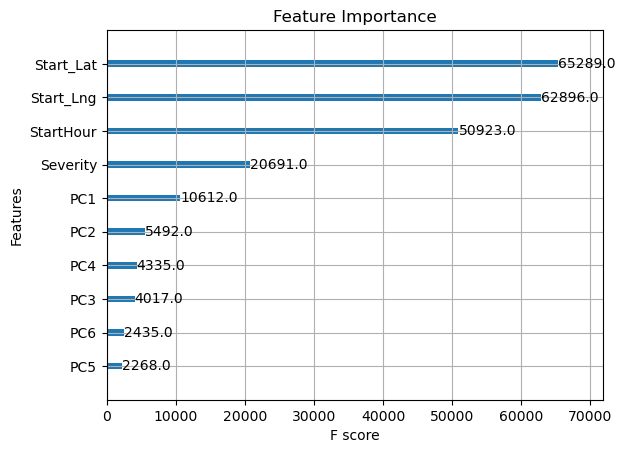

In [36]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plot_importance(bst, max_num_features=10)
plt.title('Feature Importance')
plt.show()

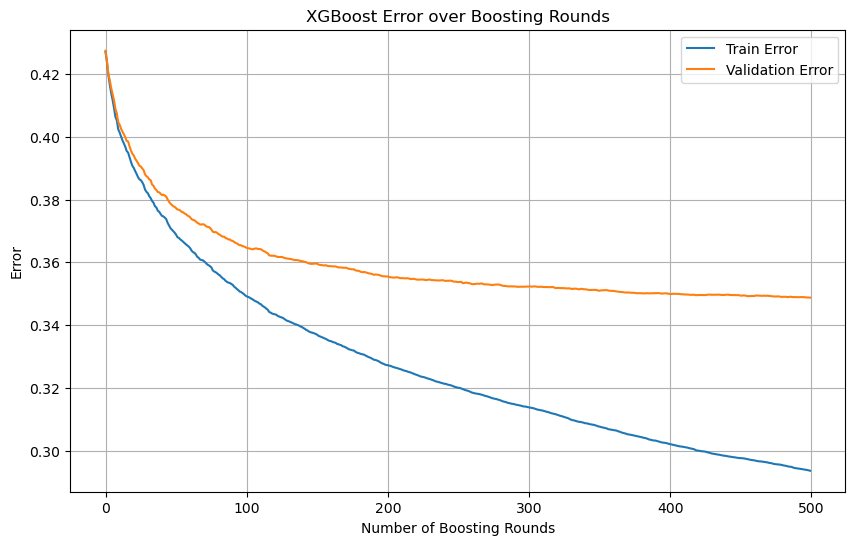

In [37]:
train_error = evals_result['train']['merror']
val_error = evals_result['eval']['merror']

train_accuracy = [error for error in train_error]
val_accuracy = [error for error in val_error]

# Plotting the error
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Train Error')
plt.plot(val_accuracy, label='Validation Error')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Error')
plt.title('XGBoost Error over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()